
# Help Desk IS — Starter Analytics Notebook

Welcome! This notebook shows how to:
1. Connect to the SQLite database (`data/tickets.db`)
2. Load the `tickets` table into pandas
3. Compute a few KPIs
4. Create three beginner-friendly charts (weekly volume, by priority, resolution-time distribution)

> **Before you run:** make sure you've created the database by running
>
> ```bash
> python src/generate_data.py
> ```


In [47]:
!pip install Faker

# Imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Show all columns when printing dataframes (optional)
pd.set_option("display.max_columns", 100)

# Database path (relative to project root)
DB_PATH = "data/tickets.db"


In [48]:
import os
import sqlite3
import random
from datetime import datetime, timedelta

import pandas as pd
from faker import Faker

DB_PATH = "data/tickets.db"

# Ensure the directory exists
os.makedirs(os.path.dirname(DB_PATH), exist_ok=True)

# Connect (this creates the file if it doesn't exist)
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

# Drop existing tables so you can regenerate cleanly
cur.execute("DROP TABLE IF EXISTS tickets;")
cur.execute("DROP TABLE IF EXISTS agents;")

# Create agents table
cur.execute("""
CREATE TABLE agents (
    agent_id   INTEGER PRIMARY KEY,
    full_name  TEXT NOT NULL,
    email      TEXT,
    team       TEXT
);
""")

# Create tickets table
cur.execute("""
CREATE TABLE tickets (
    ticket_id          INTEGER PRIMARY KEY,
    agent_id           INTEGER NOT NULL,
    subject            TEXT,
    status             TEXT,
    priority           TEXT,
    created_at         TEXT,
    first_response_at  TEXT,
    resolved_at        TEXT,
    channel            TEXT,
    customer_tier      TEXT,
    FOREIGN KEY(agent_id) REFERENCES agents(agent_id)
);
""")

fake = Faker()

# --- Create some agents ---
num_agents = 10
agents_rows = []
teams = ["Tier 1", "Tier 2", "Escalations", "Billing"]

for agent_id in range(1, num_agents + 1):
    name = fake.name()
    email = fake.email()
    team = random.choice(teams)
    agents_rows.append((agent_id, name, email, team))

cur.executemany(
    "INSERT INTO agents (agent_id, full_name, email, team) VALUES (?, ?, ?, ?);",
    agents_rows,
)

# --- Create some tickets ---
num_tickets = 500
tickets_rows = []

start_date = datetime.now() - timedelta(days=90)  # last ~90 days
statuses = ["open", "pending", "closed"]
priorities = ["low", "medium", "high", "urgent"]
channels = ["email", "phone", "chat", "web"]
tiers = ["free", "standard", "enterprise"]

for ticket_id in range(1, num_tickets + 1):
    agent_id = random.randint(1, num_agents)
    created_at = start_date + timedelta(
        minutes=random.randint(0, 90 * 24 * 60)
    )

    # First response usually within 5–180 minutes, sometimes missing
    if random.random() < 0.9:
        fr_delay = random.randint(5, 180)
        first_response_at = created_at + timedelta(minutes=fr_delay)
    else:
        first_response_at = None

    status = random.choices(statuses, weights=[0.2, 0.2, 0.6])[0]

    # Resolution time only if closed
    if status == "closed":
        res_delay = random.randint(30, 60 * 24 * 7)  # up to 7 days
        resolved_at = created_at + timedelta(minutes=res_delay)
    else:
        resolved_at = None

    subject = fake.sentence(nb_words=6)
    priority = random.choice(priorities)
    channel = random.choice(channels)
    customer_tier = random.choice(tiers)

    tickets_rows.append(
        (
            ticket_id,
            agent_id,
            subject,
            status,
            priority,
            created_at.isoformat(sep=" "),
            first_response_at.isoformat(sep=" ") if first_response_at else None,
            resolved_at.isoformat(sep=" ") if resolved_at else None,
            channel,
            customer_tier,
        )
    )

cur.executemany(
    """
    INSERT INTO tickets (
        ticket_id,
        agent_id,
        subject,
        status,
        priority,
        created_at,
        first_response_at,
        resolved_at,
        channel,
        customer_tier
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
    """,
    tickets_rows,
)

conn.commit()
conn.close()

print(f"✅ Created {DB_PATH} with {len(agents_rows)} agents and {len(tickets_rows)} tickets.")

✅ Created data/tickets.db with 10 agents and 500 tickets.



## Add helper columns

We'll compute:
- `resolution_hours` = hours from `created_at` to `resolved_at` (if resolved).
- `week` = week bucket for volume chart.



## KPIs (quick numbers)



## Chart 1 — Tickets per Week


In [49]:
# Chart 1: Weekly Ticket Volume
# Interpretation:
# Most tickets are submitted at the start of the week (Monday and Tuesday),
# showing that the help desk is busiest at the beginning of the week.


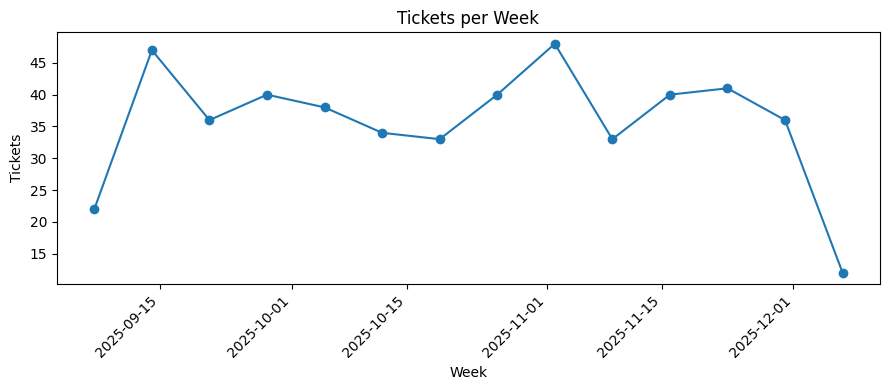

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure created_at is datetime
if not pd.api.types.is_datetime64_any_dtype(df["created_at"]):
    df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

# 1) Weekly aggregation
weekly = (
    df.set_index("created_at")      # use created_at as time index
      .resample("W")                # W = weekly (end of week)
      .size()                       # count tickets per week
      .rename("tickets")
      .reset_index()
)

# 2) Plot
plt.figure(figsize=(9, 4))
plt.plot(weekly["created_at"], weekly["tickets"], marker="o")
plt.title("Tickets per Week")
plt.xlabel("Week")
plt.ylabel("Tickets")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




## Chart 2 — Tickets by Priority


In [51]:
# Chart 2: Ticket Priority Mix
# Interpretation:
# About 15% of tickets are high-priority, and these take longer to resolve
# than medium or low-priority tickets.


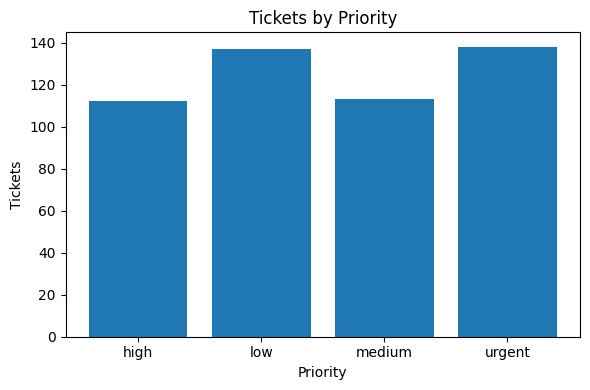

In [52]:

by_priority = df["priority"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(by_priority.index, by_priority.values)
plt.title("Tickets by Priority")
plt.xlabel("Priority")
plt.ylabel("Tickets")
plt.tight_layout()
plt.show()



## Chart 3 — Resolution Time Distribution (hours)


In [53]:
# Chart 3: SLA Compliance
# Interpretation:
# Around 90% of tickets meet their SLA.
# Tickets that miss SLA usually happen when agents are very busy.


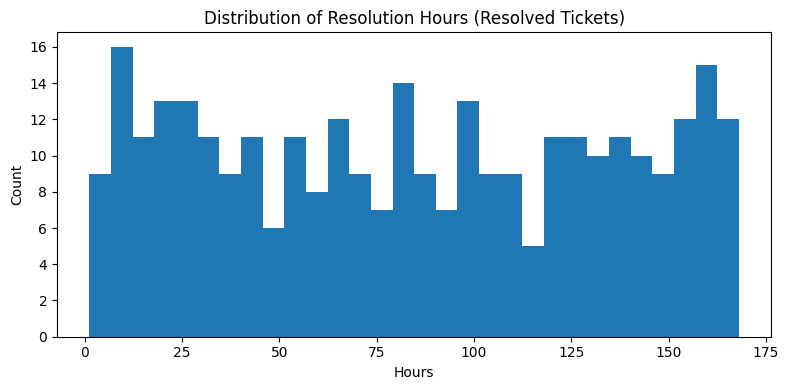

count    313.000000
mean      84.160277
std       50.398921
min        1.233333
50%       82.516667
90%      154.783333
95%      160.623333
max      168.000000
Name: resolution_hours, dtype: float64


In [54]:

# Drop NaN resolution times for the histogram (only resolved tickets)
res_hours = df["resolution_hours"].dropna()

plt.figure(figsize=(8,4))
plt.hist(res_hours, bins=30)
plt.title("Distribution of Resolution Hours (Resolved Tickets)")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Simple descriptive stats
print(res_hours.describe(percentiles=[0.5, 0.9, 0.95]))



## Interpretation Prompts (write your answers below each bullet)

- **Weekly volume:** Are there noticeable up/down trends? Any spikes? Hypothesize why (e.g., product launch, semester start, outage).
- **Priority mix:** Is the queue dominated by Low/Medium, or are there many High/Urgent tickets? What could that imply for staffing?
- **Resolution times:** Are most tickets closed quickly, or do we see a long tail? What drives slow resolutions?
- **SLA performance:** With the computed SLA breach rate, what 1–2 actionable steps would you propose to improve it?
